### Preparing training data

In [1]:
import numpy as np
import os

# path to the image directory
data_dir = "grumpycat"
# setting image shape to 32x32
img_shape = (32, 32, 3)
# all file names
images = np.sort(os.listdir(data_dir))

In [2]:
from PIL import Image

# read train data
X_train = []
for file in images:
    img = Image.open(data_dir+'/'+file)
    img = img.convert('RGB')
    img = img.resize((32,32))
    img = np.asarray(img)/255
    X_train.append(img)

In [3]:
X_train = np.array(X_train)
X_train.shape

(100, 32, 32, 3)

In [4]:
# save to npy file
np.savez_compressed('grumpycat_images_32x32.npz', X_train)

In [5]:
# load dict of arrays
dict_data = np.load('grumpycat_images_32x32.npz')
 
# extract the first array
data = dict_data['arr_0']

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d, ReLU, Tanh, Sigmoid, BCELoss 
import matplotlib.pyplot as plt 
%matplotlib inline

In [7]:
dev = 'cuda:0' if torch.cuda.is_available() == True else 'cpu'
device = torch.device(0)

In [8]:
# plot images in a nxn grid， img: numpy image vectors
 
def plot_images(imgs, row=5, col=5):
     
    fig = plt.figure(figsize = (8, 8))
    plt.title("Images")
 
    for i in range(1, col*row +1):
        plt.axis("off")
        fig.add_subplot(row, col, i)
        plt.imshow(imgs[i])
    plt.show()

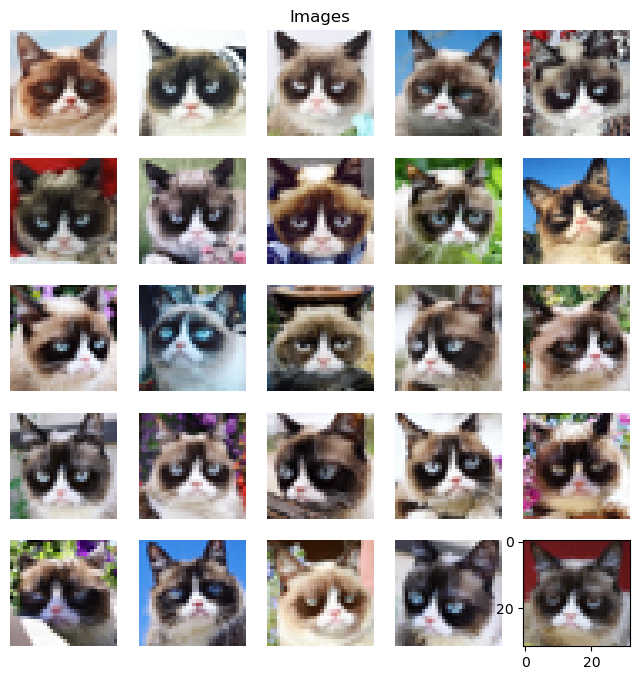

In [9]:
# load the numpy vector containing image representations
imgs = np.load('grumpycat_images_32x32.npz')
 
# sample images
plot_images(imgs['arr_0'])

In [10]:
# dataset class
class GrumpyCatDataset(Dataset):
    def __init__(self, npz_imgs):
        self.imgs = npz_imgs
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.imgs[idx]
        return image

In [11]:
# imp step to convert image size from (100, 32,32,3) to (100, 3,32,32)
transpose_imgs = np.transpose(np.float32(imgs['arr_0']), (0, 3,1,2) )

In [12]:
# dataloader for training
dataloader = DataLoader(GrumpyCatDataset(transpose_imgs), batch_size=32, shuffle=True)

### Generator/Discriminator Class

In [13]:
# generator class
# ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias)
class Generator(Module):
    def __init__(self):
        super().__init__()
 
        self.gen = Sequential(
          ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
          BatchNorm2d(num_features=512),
          ReLU(inplace=True),
 
          ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
          BatchNorm2d(num_features=256),
          ReLU(inplace=True),
 
          ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
          BatchNorm2d(num_features = 128),
          ReLU(inplace=True),
 
          ConvTranspose2d(128, 3, 4, stride=2, padding=1, bias=False),
          Tanh()
         
        )
 
    def forward(self, input):
        return self.gen(input)

In [14]:
# discriminator class
class Discriminator(Module):
    def __init__(self):
        super().__init__()
    
        self.dis = Sequential(
            Conv2d(3, 32, 4, stride = 2, padding=1, bias=False),
            LeakyReLU(0.2, inplace=True),
 
            Conv2d(32, 32*2, 4, stride = 2, padding=1, bias=False),
            BatchNorm2d(32*2),
            LeakyReLU(0.2, inplace=True),
 
            Conv2d(32*2, 32*4, 4, stride = 2, padding=1, bias=False),
            BatchNorm2d(32 * 4),
            LeakyReLU(0.2, inplace=True),
 
            Conv2d(32*4, 32*8, 4, stride=2, padding=1, bias=False),
            BatchNorm2d(32 * 8),
            LeakyReLU(0.2, inplace=True),
 
            Conv2d(32*8, 1, 2, stride = 2, padding=0, bias=False),
            Sigmoid()
        )
     
    def forward(self, input):
        return self.dis(input)

In [15]:
# initializing generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [16]:
# Adam optimization
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [17]:
# loss function - Binary Cross Entopy Loss 
loss = nn.BCELoss()

In [18]:
# noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    return n

### Training GAN

In [19]:
# TRAINING GANS
epochs = 3000
d_real = []
d_fake = []
gen = []
for e in range(epochs):
    epoch_real_loss = 0
    epoch_fake_loss = 0
    epoch_gen = 0
    count = 0;
    for i, b in enumerate(dataloader):
        # Update Discriminator
        # Loss on real images
        
        # initialize optimizer
        d_optimizer.zero_grad()
        # reshapes a 4-d tensor of shape (2,1,1,1) to 1-d tensor with 2 values
        yhat = discriminator(b.to(device)).view(-1) 
        # target labels
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # loss on real imgs
        loss_real = loss(yhat, target)
        # gradients on loss tensor
        loss_real.backward()
        
        # Loss on fake images
        
        # generate noise for generator
        noise = torch.randn(len(b), 100, 1, 1, device=device)
        # feed noise to create fake images
        fake_img = generator(noise)
        # discriminator model output on fake images
        # track steps on generator optimizer
        yhat = discriminator.cuda()(fake_img.detach()).view(-1)
        # target labels
        target = torch.zeros(len(b), dtype=torch.float, device=device)
        # loss on fake imgs
        loss_fake = loss(yhat, target)
        # gradients
        loss_fake.backward()
        
        # total Discriminator loss
        loss_disc = loss_real + loss_fake
        epoch_real_loss += loss_real.detach().cpu()
        epoch_fake_loss += loss_fake.detach().cpu()
        # Update weights of discriminator
        d_optimizer.step()
        
        # Update Generator
        # clear gradient
        g_optimizer.zero_grad()
        # pass fake images to discriminator
        yhat = discriminator.cuda()(fake_img).view(-1)
        # specify target variables
        target = torch.ones(len(b), dtype=torch.float, device=device)
        loss_gen = loss(yhat, target)
        loss_gen.backward()
        g_optimizer.step()
        # collect loss
        epoch_gen += loss_gen.detach().cpu()
        count += len(b)
        
    
    d_real.append(epoch_real_loss)
    d_fake.append(epoch_fake_loss)
    gen.append(epoch_gen/count)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

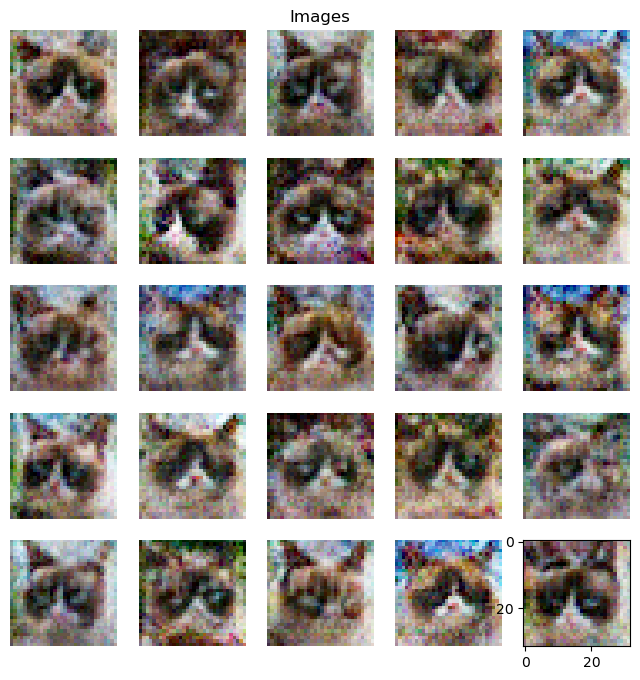

In [20]:
noise = torch.randn(26, 100, 1, 1, device=device)
# convert fake images from (b_size, 3, 32, 32) to (b_size, 32, 32, 3)
fake_img = generator(noise)
img_plot = np.transpose(fake_img.detach().cpu(), (0,2,3,1))
plot_images(img_plot)

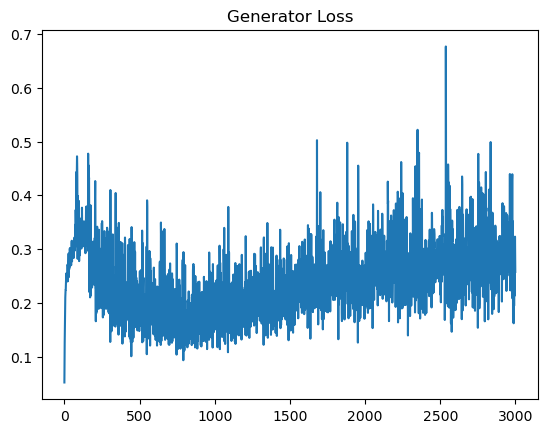

In [22]:
# plot generator loss
plt.plot(gen)
plt.title("Generator Loss")
plt.show()